# Find stars

This notebook combines the procedures developed in `Background.ipynb` and `White_light_images.ipynb` notebooks to build images suitable for star finding. Then it applies `photutils` tools to find star images and build  tables with centroid locations. 

There is also a statistical analysis to see how star shapes depend on the RGB normalization coefficients. 

Later we proceed to find stars in two contiguous images in the sequence, to see how to correlate the detections that are stored in two separate tables.

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table
from astropy.io import fits
from astropy.stats import SigmaClip

import photutils
from photutils import Background2D, ModeEstimatorBackground, DAOStarFinder, CircularAperture

import rawpy

Populating the interactive namespace from numpy and matplotlib


In [2]:
# test image
fname = '../astrophotography_data/MilkyWayPrettyBoy/tests/12800_DSC03779.ARW'
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [3]:
# masks that isolate the RGB pixels 
colors_array = raw.raw_colors_visible
mask = np.ones(shape=colors_array.shape)

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

Use normalization factors determined in `White_light_images.ipynb` notebook for the same raw image.

In a more flexible application, one should include the minimization step as part of this workflow.

In [4]:
# normalization factors
red_norm = 1.321875  # smooth background
green_norm = 1.
blue_norm = 1.27695312

# red_norm = 1.36  # max roundness
# green_norm = 1.
# blue_norm = 1.46

In [5]:
# build raw image with "normalized" RGB subarrays. Explictly ignore flat field.
raw_norm_1 = imarray * (red_mask * red_norm)
raw_norm_2 = raw_norm_1 + imarray * (green_mask * green_norm)
raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)

In [6]:
# handle saturated pixels
raw_norm = np.where(imarray > 16380, imarray, raw_norm)

<IPython.core.display.Javascript object>


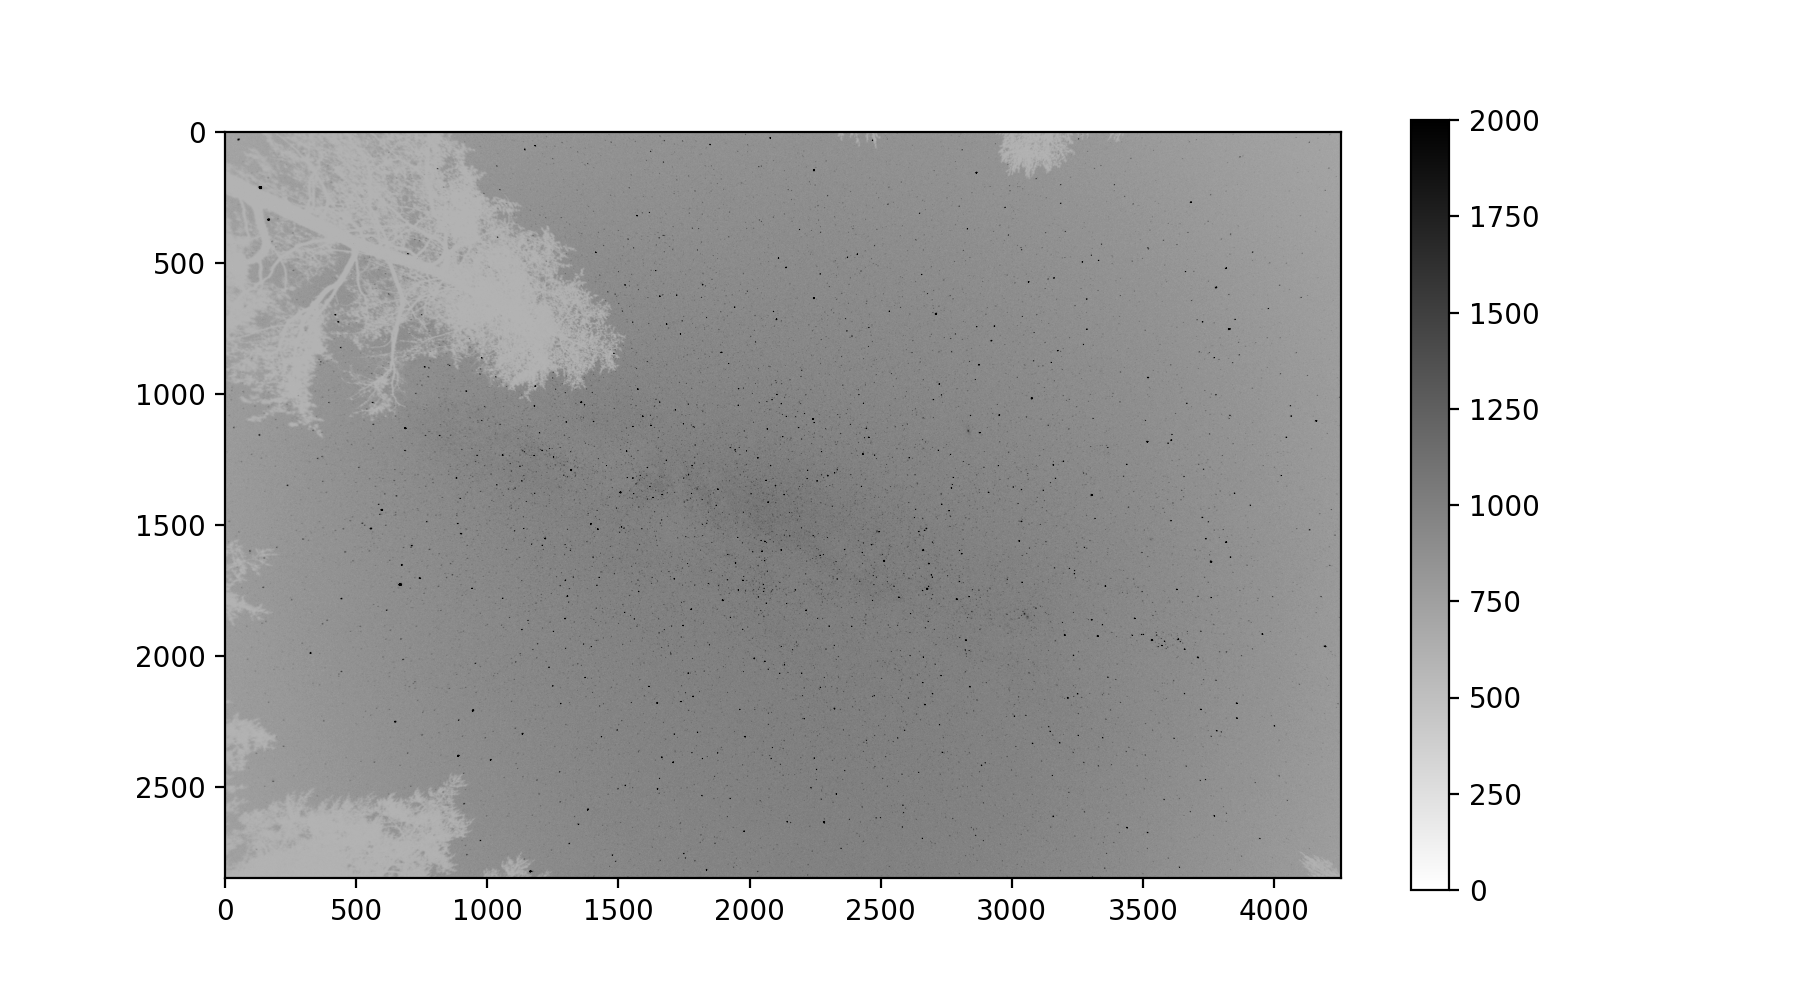

21321.84375
Relative standard deviation of a smooth patch:  0.08636338453617722


In [7]:
plt.figure(figsize=[9, 5])
print(np.max(raw_norm))
plt.imshow(raw_norm, vmin=0, vmax=2000, cmap='binary')
# plt.imshow(raw_norm, vmax=28000, cmap='gist_stern')
plt.colorbar()

section = raw_norm[750:810,3320:3380]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.median(section))

In [8]:
# estimate background
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = ModeEstimatorBackground()
bkg = Background2D(raw_norm, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

<IPython.core.display.Javascript object>


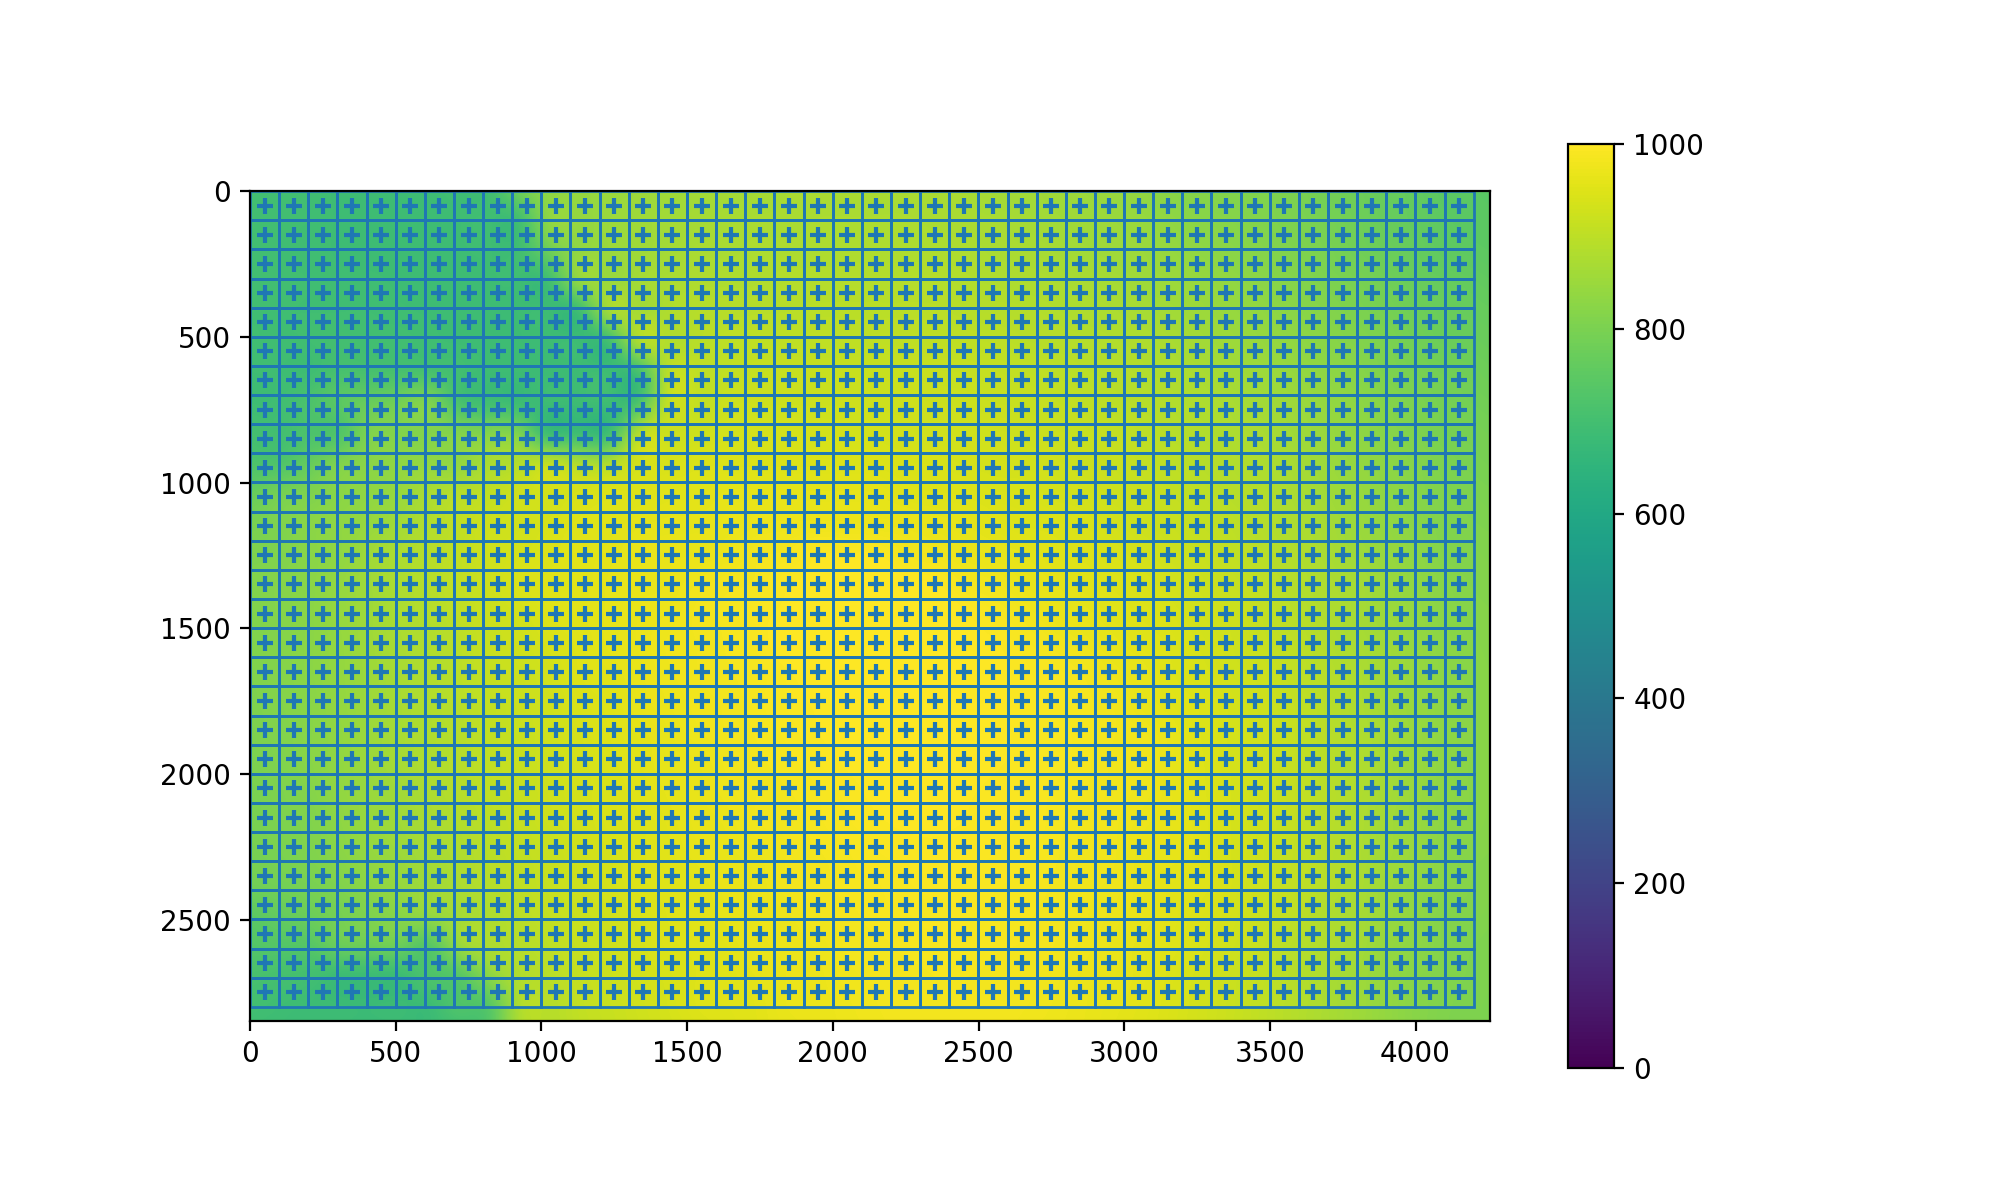

In [9]:
plt.figure(figsize=[10, 6])
plt.imshow(bkg.background, vmin=0, vmax=1000)
bkg.plot_meshes(outlines=True, color='#1f77b4')
plt.colorbar()

In [10]:
subtracted = raw_norm - bkg.background

<IPython.core.display.Javascript object>


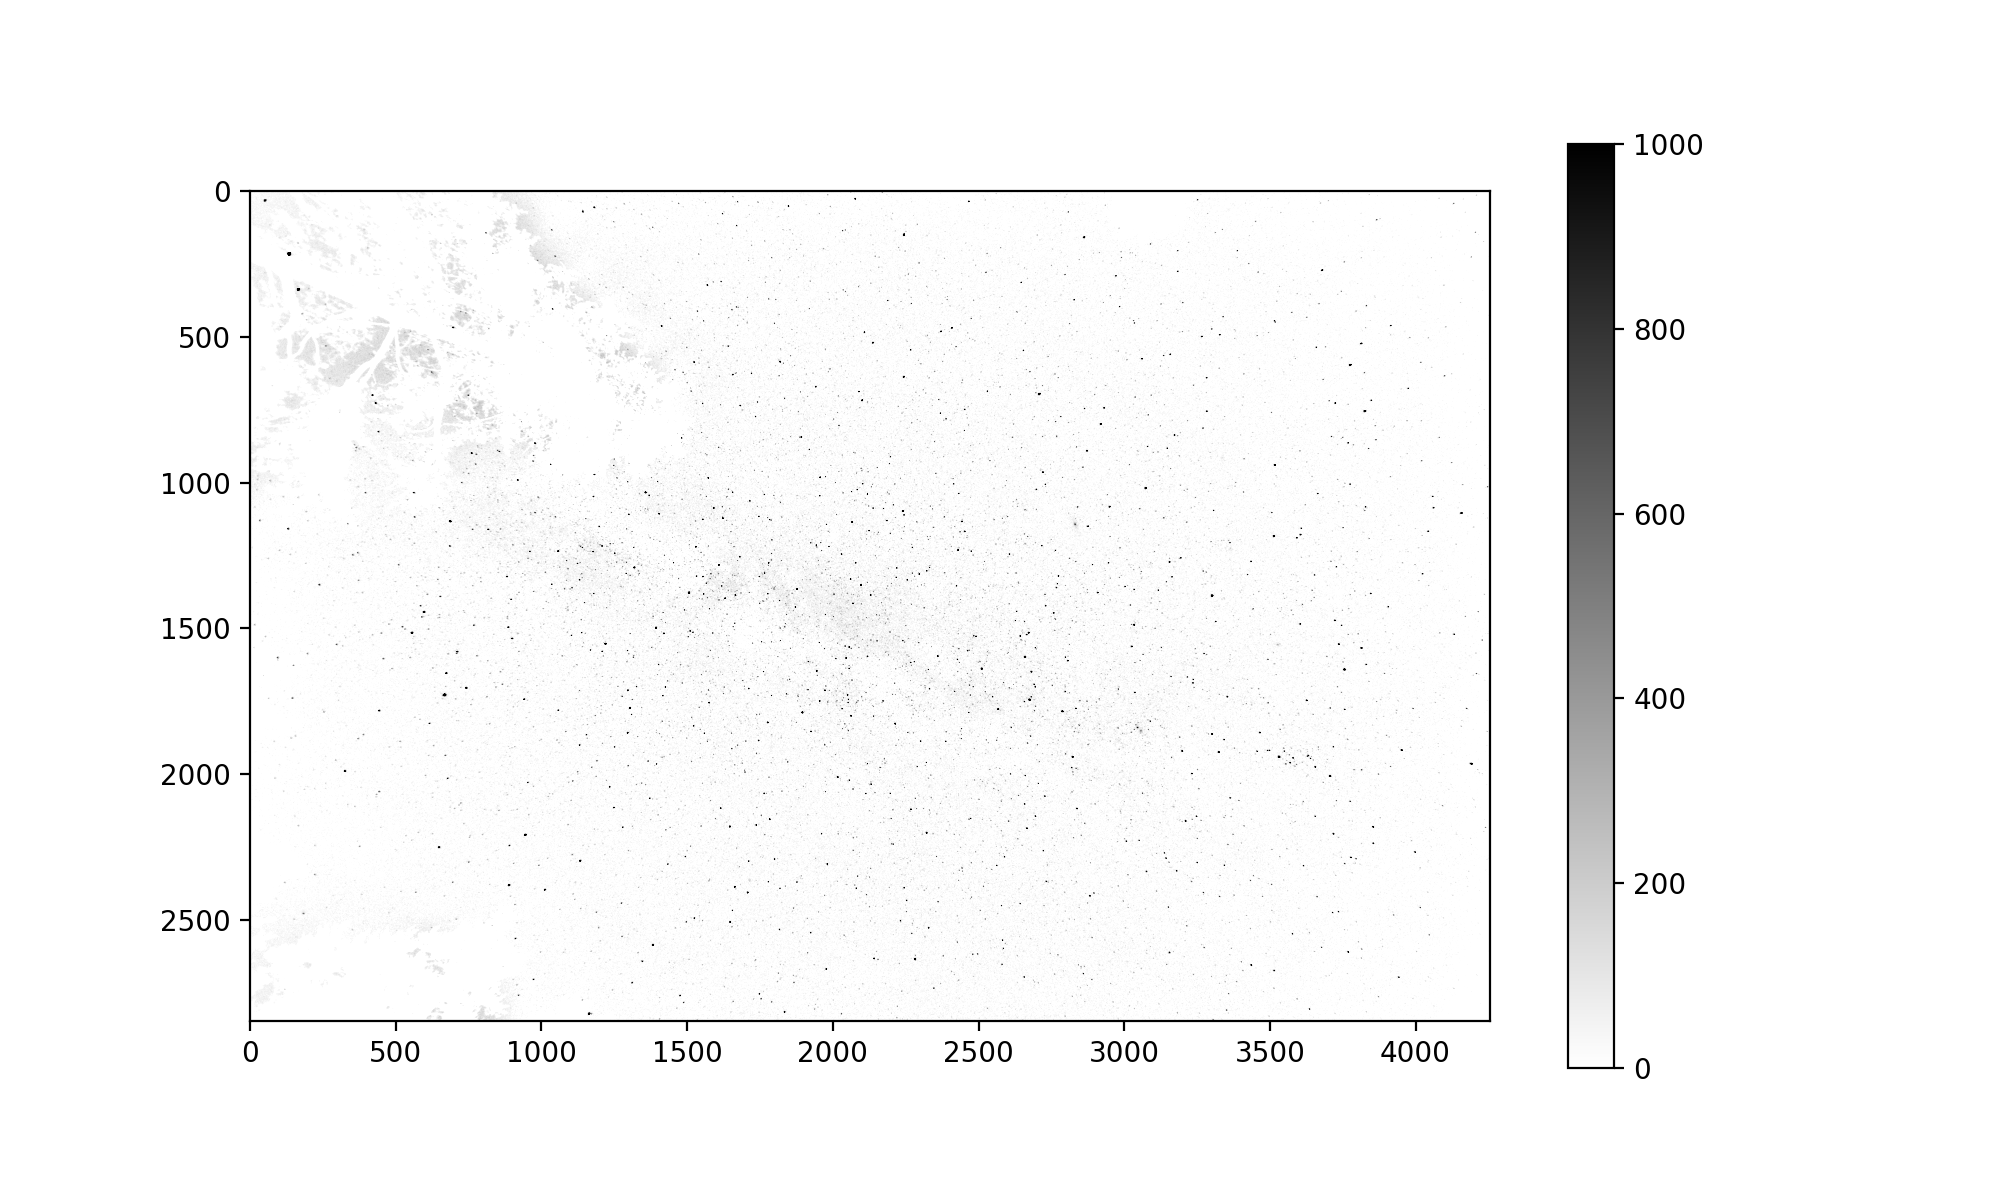

In [11]:
plt.figure(figsize=[10, 6])
plt.imshow(subtracted, vmin=0, vmax=1000, cmap='binary')
plt.colorbar()

In [12]:
# find star images
daofind = DAOStarFinder(fwhm=3.0, 
                        threshold=6.*bkg.background_rms_median)  

# can't be too strict with these. Many images are very non-circular 
# and non-Gaussian due to strong undersampling
#                         sharplo=0.1, sharphi=0.8,
#                         roundlo=-0.7, roundhi=0.7,

sources = daofind(subtracted)  

In [13]:
for col in sources.colnames:  
    sources[col].info.format = '%.5g'  # for consistent table output
print(sources)  

 id  xcentroid ycentroid sharpness roundness1 ... sky  peak   flux     mag    
---- --------- --------- --------- ---------- ... --- ------ ------ ----------
   1      3725    0.2622   0.80339   -0.21498 ...   0 556.55 1.0912  -0.094788
   2      1629    2.9901   0.80996   -0.43203 ...   0 739.06 1.2819   -0.26966
   3    2061.4    4.4853   0.79876    0.55966 ...   0  728.1 1.2823   -0.26993
   4    2169.4    4.0022   0.75674    0.39135 ...   0 1664.1 2.9155    -1.1618
   5    2560.8    7.9935   0.58432   -0.18702 ...   0 640.96  1.443   -0.39818
   6    2803.1     10.58   0.60961   -0.44346 ...   0 636.78 1.3451   -0.32186
   7    1982.8    12.238   0.65017    0.61846 ...   0 1343.3 2.4863   -0.98888
   8    3841.2    11.417   0.78503   -0.73876 ...   0 778.92 1.4057   -0.36973
   9    4209.5    13.609   0.67584   -0.85239 ...   0 718.79 1.3755   -0.34614
  10    2411.9    15.524    0.8885   -0.50679 ...   0 819.17 1.5782    -0.4954
 ...       ...       ...       ...        ... ... ..

In [14]:
# statistics
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

Mean roundness:  -0.017795865559439177 stdev:  0.39432928656103033
Mean sharpness:  0.6558711540974037 stdev:  0.21341030392570962


<IPython.core.display.Javascript object>


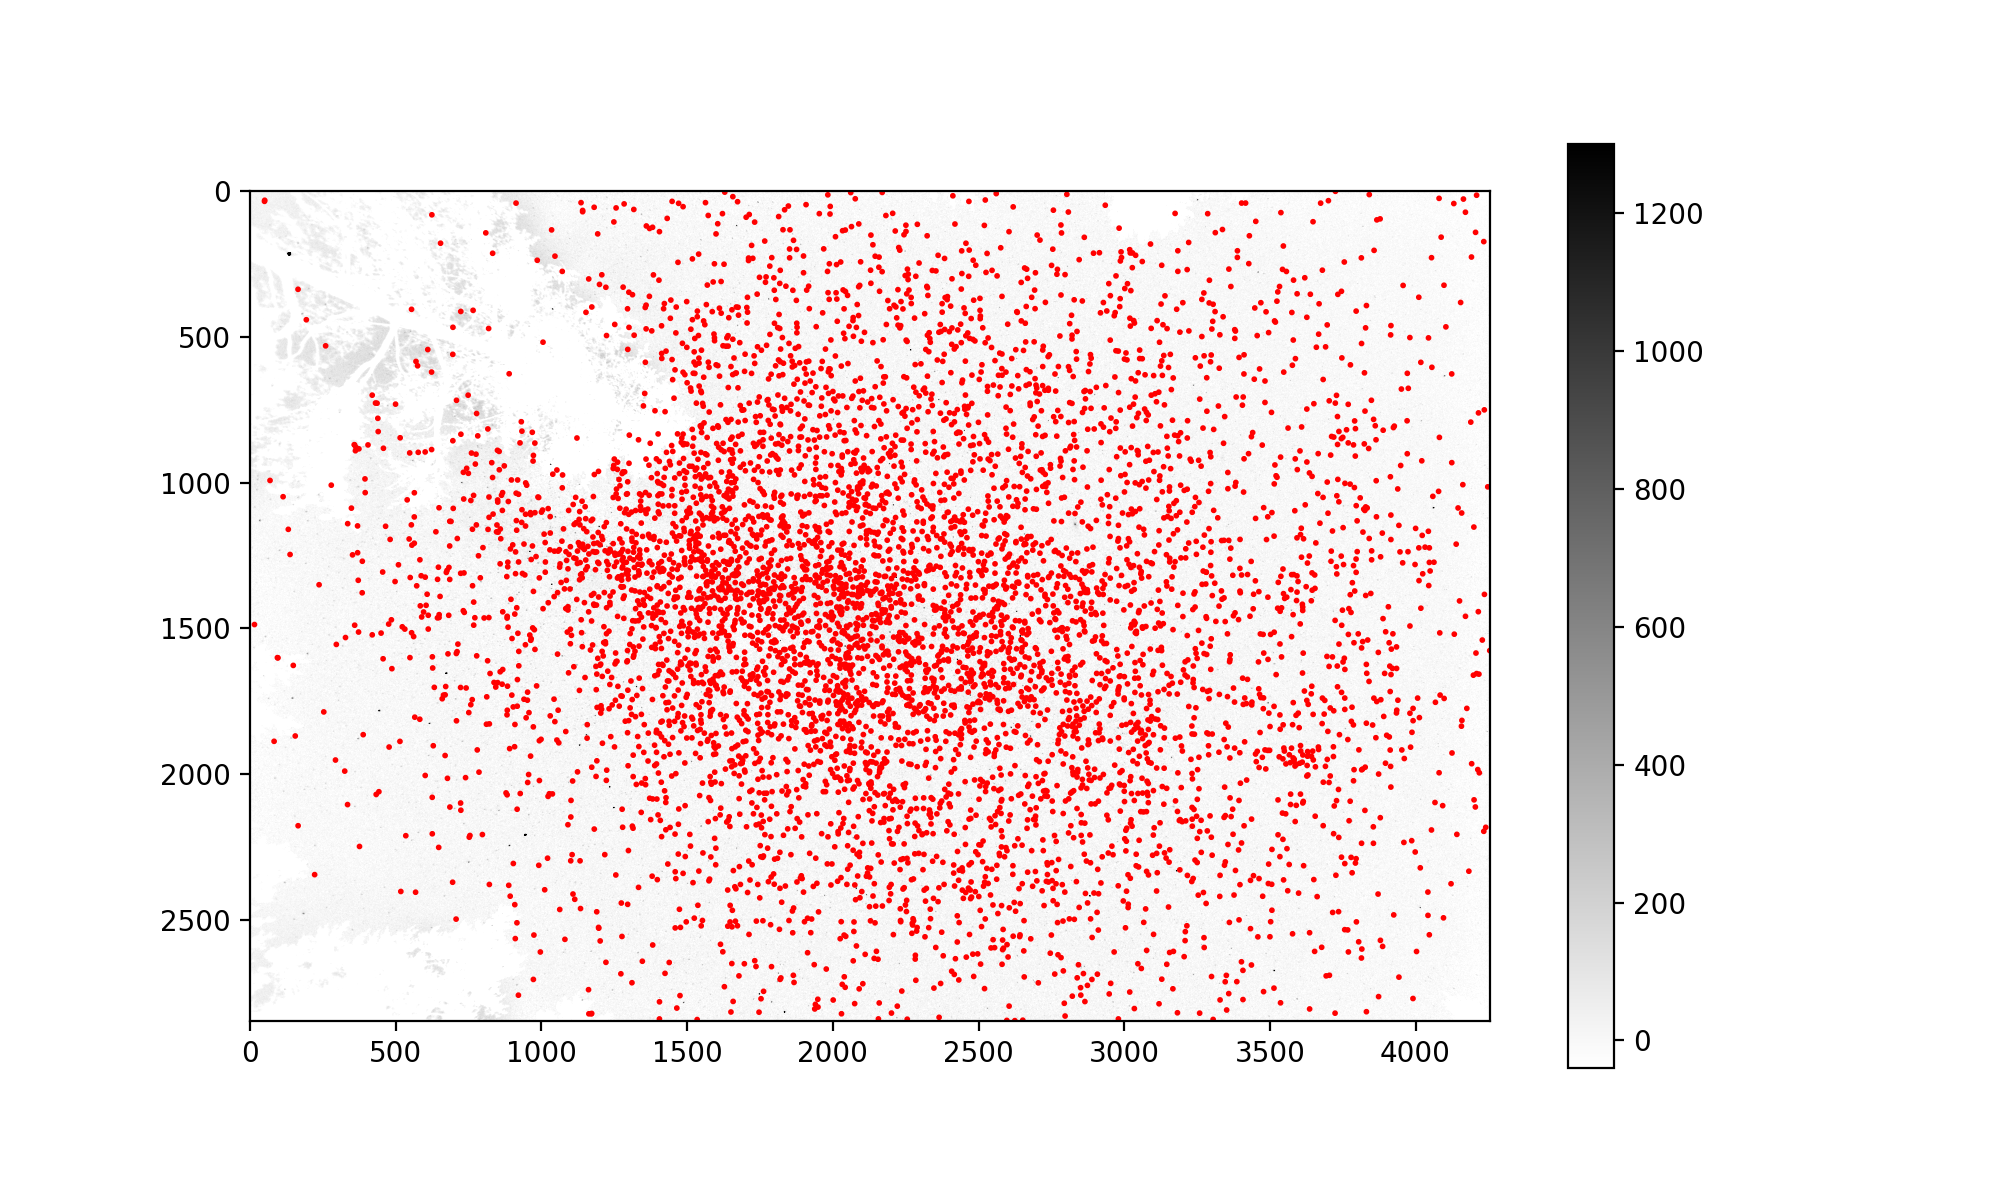

In [15]:
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=5.)
plt.figure(figsize=[10, 6])
plt.imshow(subtracted, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap = apertures.plot(color='red')

## Statistical analysis

In [16]:
# optimization functions
def stats(table):
    mean_roundness = np.average(table['roundness1'])
    mean_sharpness = np.average(table['sharpness'])
    
    print(mean_roundness)

    return abs(mean_roundness)

def objective_function(coeffs):
    
    red_norm = coeffs[0]
    blue_norm = coeffs[1]
    
    raw_norm_1 = imarray * (red_mask * red_norm)
    raw_norm_2 = raw_norm_1 + imarray * (green_mask * 1.0)
    raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)
    
    raw_norm = np.where(imarray > 16380, imarray, raw_norm)
    
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = ModeEstimatorBackground()
    bkg = Background2D(raw_norm, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    subtracted = raw_norm - bkg.background
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=6.*bkg.background_rms_median)  
    sources = daofind(subtracted)
    
    return stats(sources)  

In [17]:
# res = minimize(objective_function, (1.3, 1.3), method='Nelder-Mead', tol=1e-2)
# print(res.x, res.fun)

### Conclusion

It appears that optimizing for sharpness or roundness doesn't lead to any significant gain in star image conditioning. Too high sharpness causes star images to become crosses. Too low roundness discards a lot of apparently good star images. 

Assuming that DAOfind is optimizing for a Gaussian profile, we can safely assume that the best approach is to optimize for minimum background scatter and leave it at that.

## Correlate two contiguous images

In [21]:
fname2 = '../astrophotography_data/MilkyWayPrettyBoy/tests/12800/DSC03780.ARW'
raw2 = rawpy.imread(fname2)
imarray2 = raw2.raw_image_visible.astype(float)

LibRawIOError: b'Input/output error'

In [20]:
raw_norm_1_2 = imarray2 * (red_mask * red_norm)
raw_norm_2_2 = raw_norm_1_2 + imarray2 * (green_mask * 1.0)
raw_norm2 = raw_norm_2_2 + imarray2 * (blue_mask * blue_norm)

raw_norm2 = np.where(imarray2 > 16380, imarray2, raw_norm2)

sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = ModeEstimatorBackground()
bkg2 = Background2D(raw_norm2, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
subtracted2 = raw_norm2 - bkg2.background

daofind = DAOStarFinder(fwhm=3.0, threshold=6.*bkg2.background_rms_median)  
sources2 = daofind(subtracted2)

NameError: name 'imarray2' is not defined

In [ ]:
for col in sources2.colnames:  
    sources2[col].info.format = '%.5g'  # for consistent table output
print(sources2)  